In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib.colors import LightSource
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.special as sp
from mpl_toolkits.basemap import Basemap
import pandas as pd
from matplotlib import rcParams
rcParams['text.usetex'] = True
import ipywidgets as widgets
from matplotlib import rc
import glob
import os, imageio
#import warnings; warnings.simplefilter('ignore')
#import textwrap as tw
rcParams['animation.html'] = 'html5'

In [2]:
def drawsphere(l,m,rotation=0,cent_lat=45,cent_lon=-100):

    # This function is originally found on https://stackoverflow.com/questions/34397418/python-combine-plots-in-grid
    # Only slightly adapted
    
    res = np.pi/250 # resolution

    theta = np.r_[0:2*np.pi:res]+rotation
    phi = np.r_[0:np.pi:res] # theta: lon, phi: coalt

    coef = []
    for i in theta:
        for j in phi:
            coef.append(sp.sph_harm(m,l,i,j))
    coef = np.asarray(coef) # convert list to array
    coef = np.reshape(coef, (len(theta),-1)) # reshapte array as per number of angles

    ## Plotting ##

    # create latitude/longitude arrays
    lon = np.linspace(0,2*np.pi,len(theta))
    lat = np.linspace(-np.pi/2,np.pi/2,len(phi))
    colat = lat+np.pi/2 # colatitude array
    # create 2D meshgrid
    mesh_grid = np.meshgrid(lon, lat) # create a meshgrid out of lat/lon
    lon_grid = mesh_grid[0] # grab the meshgrid part for lon
    lat_grid = mesh_grid[1] # grab the meshgrid part for lat

    real_coef = np.real(coef) # read parts of the coefficients
    norm_coef = np.round(real_coef / np.max(real_coef),2) # normalize
    # set up orthographic map projection
    mp = Basemap(projection='ortho', lat_0 = cent_lat, lon_0 = cent_lon) 
    # setup an orthographic basemap centered at lat_0 & lon_0
    # draw the edge of the map projection region (the projection limb)
    mp.drawmapboundary()

    # convert angles from radians to degrees & pipe them to basemap
    x,y = mp(np.degrees(lon_grid), np.degrees(lat_grid)) 
    # cax = figure.add_axes([0.15,0.03,0.7,0.03])
#         cb = plt.colorbar(orientation = 'horizontal')
    return mp,x, y, norm_coef

In [3]:
def gif_maker(gif_name,png_dir,gif_indx,num_gifs,dpi=90):

    # This function is taken from https://github.com/makerportal/rotating_globe
    # Only very minor changes
    
    if gif_indx==num_gifs-1:
        # sort the .png files based on index used above
        images,image_file_names = [],[]
        for file_name in os.listdir(png_dir):
            if file_name.endswith('.png'):
                image_file_names.append(file_name)       
        sorted_files = sorted(image_file_names, key=lambda y: int(y.split('_')[1]))

        # define some GIF parameters
        
        frame_length = 0.1 # seconds between frames
        end_pause = 0.1 # seconds to stay on last frame
        # loop through files, join them to image array, and write to GIF called 'wind_turbine_dist.gif'
        for ii in range(0,len(sorted_files)):       
            file_path = os.path.join(png_dir, sorted_files[ii])
            if ii==len(sorted_files)-1:
                for jj in range(0,int(end_pause/frame_length)):
                    images.append(imageio.imread(file_path))
            else:
                images.append(imageio.imread(file_path))
        # the duration is the time spent on each image (1/duration is frame rate)
        imageio.mimsave(gif_name, images,'GIF',duration=frame_length)

In [4]:
setl = widgets.IntSlider(
        value=6,
        min=0,
        max=12,
        description=r'$\ell: $',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
  )
display(setl)

IntSlider(value=6, description='$\\ell: $', max=12)

In [10]:
setm = widgets.IntSlider(
        value=setl.value,
        min=0,
        max=max([0,setl.value-1]),
        description=r'$m: $',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
  )
display(setm)

IntSlider(value=5, description='$m: $', max=5)

In [11]:
l = setl.value
m = setm.value

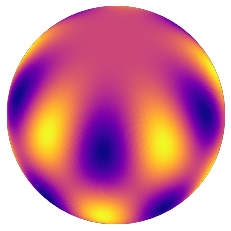

In [12]:
cmap = cm.get_cmap('plasma') # Set color map

mp, x, y, norm_coef = drawsphere(l,m)
mp.pcolor(x,y,np.transpose(norm_coef), cmap=cmap)

rotation = np.linspace(0,2*np.pi,50)

png_dir="./png_dir/"
gif_indx = 0
plt.savefig("./osc_l"+str(l)+"m"+str(m)+".png",bbox_inches="tight")

In [13]:
for r in rotation: 
    plt.cla()
    fig = plt.gcf()
    fig_size = fig.get_size_inches()    
    mp, x, y, norm_coef = drawsphere(l,m,rotation=r)
    mp.pcolor(x,y,np.transpose(norm_coef),cmap=cmap)
    bbox = matplotlib.transforms.Bbox([[0.0,0.0],[fig_size[0],fig_size[1]]])
    plt.savefig(png_dir+'frame_'+str(gif_indx)+'_.png',dpi=90,facecolor=fig.get_facecolor(),bbox_inches=bbox,pad_inches=1)
    plt.close()
    plt.ioff()
    #show the plot, introduce a small delay to allow matplotlib to catch up
    gif_indx+=1
    gif_maker("movie_l"+str(l)+"m"+str(m)+".gif",png_dir,gif_indx,num_gifs=len(rotation),dpi=3000)
files = glob.glob(png_dir+'/*png')
for f in files:
    os.remove(f)